In [1]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from gitstats import NWBGitInfo, GitHubRepoInfo
from renderstats import plot_release_timeline, plot_multiple_release_timeslines

In [2]:
import git
import requests
from datetime import datetime, timedelta
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import time
%matplotlib inline

In [3]:
github_repo_infos = NWBGitInfo.GIT_REPOS.get_info_objects()

# Select main repos for plotting
select_github_repo_infos = OrderedDict(
    [(k, github_repo_infos[k]) 
      for k in  ['PyNWB', 'HDMF', 'MatNWB', 'NWB_Schema', 'HDMF_Common_Schema']
    ]
)

# Plot the release timeline

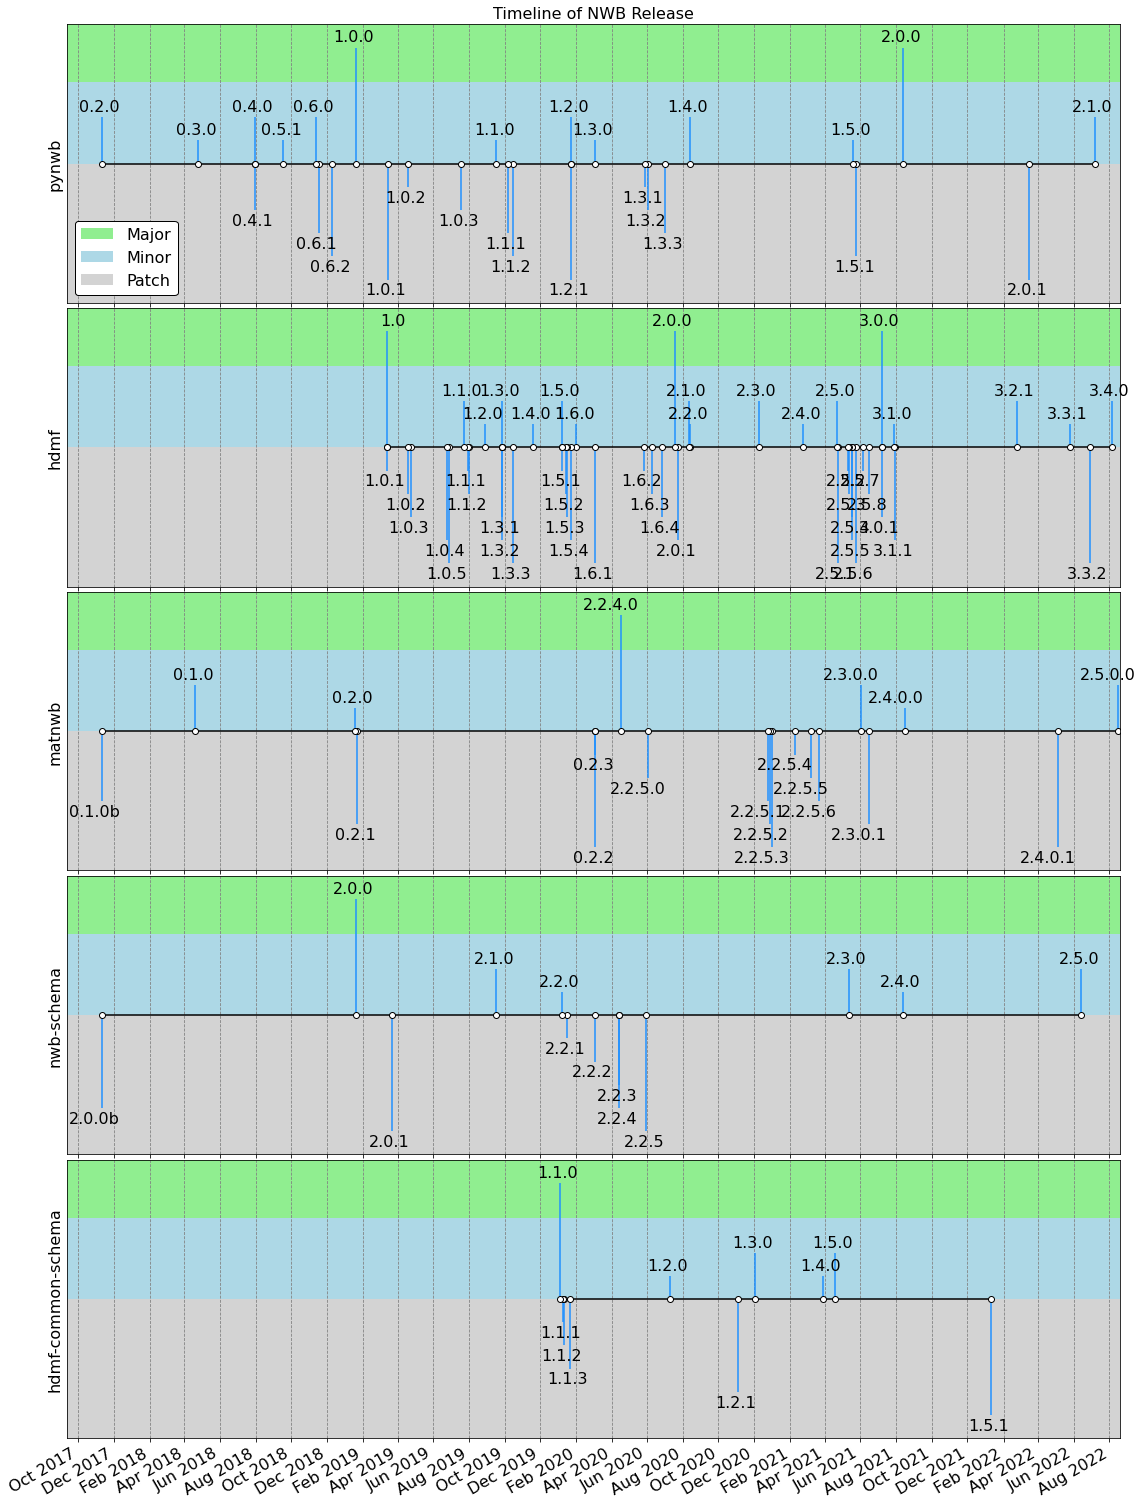

In [4]:
plot_multiple_release_timeslines(
    github_repo_infos=select_github_repo_infos,
    add_releases=None, # Use default of NWBGitInfo.MISSING_RELEASE_TAGS,
    date_range=None,   # Use the default range of
    month_intervals=2,
    fontsize=16,
    title="Timeline of NWB Release")
plt.savefig('nwb_software_releases_timeline.pdf', dpi=300)
plt.savefig('nwb_software_releases_timeline.png', dpi=300)
plt.show()

# Plot timeline with code stats

The following example illustrates plotting of code statistics along with the release history. This relies on the output of the cloc_code_stats.ipynb notebook.

In [5]:
from codestats import GitCodeStats
import pandas as pd
cloc_data_dir = os.path.join(os.getcwd(), 'data')
if GitCodeStats.cached(cloc_data_dir):
    git_code_stats = GitCodeStats.from_cache(cloc_data_dir)
    date_range = pd.date_range(start=NWBGitInfo.HDMF_START_DATE, 
                               end=git_code_stats.cloc_stats['HDMF'][0]['date'], 
                               freq="D")
    code_summary_stats = git_code_stats.compute_summary_stats(date_range=date_range) 
    # Clean up HDMF stats to ignore data from before HDMF was extracted from PyNWB
    for k in code_summary_stats.keys():
        code_summary_stats[k]['HDMF'][:NWBGitInfo.HDMF_START_DATE] = 0
else:
    git_code_stats = None
    print("No cached code stats available")

Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/nwb_project_analytics/notebooks/data/cloc_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/nwb_project_analytics/notebooks/data/commit_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/nwb_project_analytics/notebooks/data/git_paths.yaml


NameError: name 'git_repo_infos' is not defined

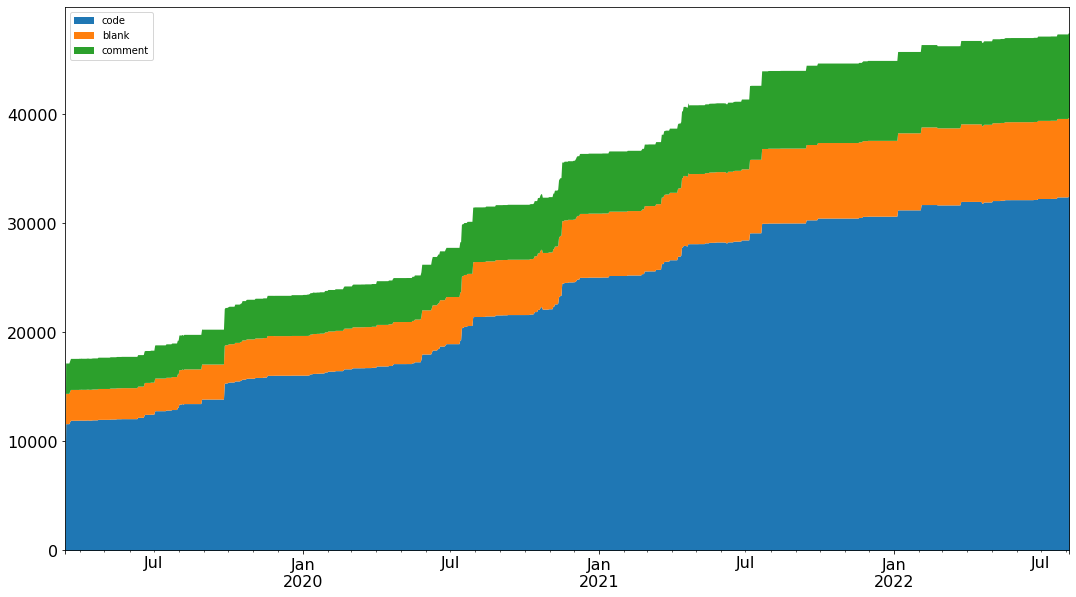

In [6]:
if git_code_stats:
    k = 'HDMF'
    curr_df = pd.DataFrame.from_dict({'code': code_summary_stats['codes'][k], 
                                      'blank': code_summary_stats['blanks'][k], 
                                      'comment': code_summary_stats['comments'][k]})
    curr_df.index = date_range
    ax = curr_df.plot.area(
        figsize=(18,10), 
        stacked=True, 
        linewidth=0, 
        fontsize=16)
    
    # Choose some nice levels
    names, dates = git_repo_infos[k].get_release_names_and_dates()
    version_jumps = GitHubRepoInfo.get_version_jump_from_tags(names)
    levels = []
    curr_minor = 5000
    curr_patch = 700
    for n in names:
        if version_jumps[n] == "major":
            levels.append(8000)
        elif version_jumps[n] == "minor":
            levels.append(curr_minor)
            curr_minor += 1000
            if curr_minor > 6000:
                curr_minor = 5000
        else:
            levels.append(curr_patch)
            curr_patch += 700
            if curr_patch > 3000:
                curr_patch = 1500
    
    ax.vlines(dates, 0, levels, color="white")  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.
    # annotate lines
    for d, l, r in zip(dates, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(14+2, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top",
                    fontsize=20 if version_jumps[r] == "major" else 16 if version_jumps[r] == "minor" else 12,
                    color='white')

    plt.legend(loc=2, prop={'size': 16})
    plt.ylabel('Lines of Code (CLOC)', fontsize=16)
    plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
    plt.title("Lines of Code: %s" % k, fontsize=20)
    plt.tight_layout()
    plt.show()
